## Libraries

### Import Data Analytics Libraries
- Pandas
- Numpy
- Matplotlib
- Datetime

In [51]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler

### Import Project Specific Libraries
- **Yahoo Finance (yfinance)**: Gather ticker data
- **Backtrader Technical Analysis Library (bta-lib)**: Gather trends and pattern indicators

In [3]:
import btalib
import yfinance as yf

### Import Web Scraping Libraries
- **requests**: Gather web data
- **urllib**: Gather web data
- **BeautifulSoup**: Extract web data

In [4]:
import requests
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

### Import Deep Learning Libraries
- **PyTorch**: Create neutral networks


In [5]:
import torch

### Import Natural Language Processing Tools
- **transformers**: Use pre-trained deep learning models

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

### Import API Keys
- **config**: Holds all private API keys


In [7]:
from config import *

## Data Collection

We will be using Yahoo Finance in order to find the ticker data. This data will include:

- **Date/DateTime**: Index
- **Open**: Price of asset at beginning of Date/Datetime
- **High**: Highest price of asset during Date/Datetime
- **Low**: Lowest price of asset during Date/Datetime
- **Close**: Price of stock at end of Date/Datetime
- **Adj Close**: Close price adjusted due to corporate actions such as dividend payouts, stock splits, or the issuance of more shares

In [8]:
def get_data(symbol, interval = "1d", start_date = "2019-10-26", end_date = "2022-01-26"):
   
    '''
    Returns asset information

            Parameters:
                    symbol (string): ticker symbol for lookup
                    interval (string): periods between datapoints (valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo)
                    start_date (string): format YYYY-MM-DD
                    end_date (string): format YYYY-MM-DD
            Returns:
                    (DateFrame): Asset Information  
    '''

    return yf.download(symbol, start=start_date, end=end_date, interval=interval)

In [9]:
data = get_data("AAPL")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-28,61.855000,62.312500,61.680000,62.262501,61.089710,96572800
2019-10-29,62.242500,62.437500,60.642502,60.822498,59.676834,142839600
2019-10-30,61.189999,61.325001,60.302502,60.814999,59.669479,124522000
2019-10-31,61.810001,62.292500,59.314999,62.189999,61.018578,139162000
2019-11-01,62.384998,63.982498,62.290001,63.955002,62.750328,151125200


# Feature Construction

## Technical Analysis

A part of this study is to try and see if a model can use technical analysis (TA) as a way to create a trading strategy

Technical analysis is the study of trends and patterns in order to predict profitable trading decisions. There are 4 types of indictors we will in this study:

- trend indictors
- momentum indicators
- volatility indicators
- volume indicators. 

Typically, traders use only a 2-3 indictors for their strategy, however, our job is to also see if a model can determine which indictors are more important when making these decisions as well.

In order to add TA to our data, we will be using bta-lib.

Below, we will go in depth into a few indictors and how they are used

### Simple Moving Average

The simple moving average indictor is a trend indictor that finds the average price within a certain window of time. This helps smooth out the noise in price changes and helps trades seen the general trend of the asset's price.

Many traders also use two different moving averages on the same asset. One moving average would have a longer period than the other. In order to buy, the shorter moving average would have to greater than the longer moving average, indicating that there is a rapid change in price upwards. The same is true vice versa.

We will test if the model could potentially recognize this pattern and gauge if it is useful.



![SMA](images/SMA.PNG)

This chart shows Apple stock prices using the moving average indictors. The purple line shows the short term moving average of 12 days and the yellow line shows the long term moving average of 26 days. The green "up" arrow shows where a trader would buy and the red "down" arrow shows where a trader would sell using this strategy.

In [10]:
def get_MA(data, short_period=12, long_period=26):

    '''
    Adds Moving Averages to asset data

        Parameters:
                data (DataFrame): asset data
                short_period (int): period over moving average taken (<long_period)
                long_period (int): period over moving average taken (>short_period)

        Returns:
                (DateFrame): Asset Information
    '''

    # get Moving Averages
    ShortMA = btalib.sma(data, period=short_period)
    LongMA = btalib.sma(data, period=long_period)

    # add to current data
    data["ShortMA"] = ShortMA.df
    data["LongMA"] = LongMA.df

    return data

### Exponential Moving Average

The exponential moving average is similar to the simple moving average, however, it gives higher weigh to more recent changes within the window of time. This could better help find short term price trends than the simple moving average.

Note: may only use this rather than the simple moving average for the model.

![EMA](images/EMA.PNG)

This chart shows Apple stock prices using the exponential moving average indictors. The purple line shows the short term moving average of 12 days and the yellow line shows the long term moving average of 26 days. The green "up" arrow shows where a trader would buy and the red "down" arrow shows where a trader would sell using this strategy.

In [11]:
def get_EMA(data, short_period=12, long_period=26):
    '''
    Adds Exponential Moving Averages to asset data

        Parameters:
                data (DataFrame): asset data
                short_period (int): period over moving average taken (<long_period)
                long_period (int): period over moving average taken (>short_period)

        Returns:
                (DateFrame): Asset Information 
    '''
    # get Exponential Moving Averages
    ShortEMA = btalib.ema(data, period=12)
    LongEMA = btalib.ema(data, period=26)
    
    # add to data
    data["ShortEMA"] = ShortEMA.df
    data["LongEMA"] = LongEMA.df

    return data

### Bollinger Bands


The Bollinger Bands indictors is a kind of volatility indictor which uses the moving average over a portion of days and finds a certain standard deviation above and below that moving average. This indictor relies on the theory of mean reversion where asset prices, after spikes in price changes, revert towards the moving average of price. This indictor also shows how volatile an asset is; if the bands are farther apart, then more volatile the asset is. Traders may use this strategy by buying an asset when the price reaches the lower standard deviation and then sell at the higher standard deviation. Usually, traders use 2 standard deviations away from the mean and have a moving average window of 20 periods.

![Simple Bollinger Bands](images/simpleBBands.PNG)

The purple lines are two standard deviations and the yellow line is the moving average.

Of course, this strategy by itself or unaltered is not perfect, as it may miss out on trends. However, with stop losses (selling if price drops below certain value), band line slopes, and pattern recognition, this strategy may help the model learn more about correct buy and sell signals.

Another possible way to improve this strategy is to add another set of Bollinger Bands that have a different standard deviation.

![Double Bollienger Bands](images/doubleBBands.PNG)

Now the added blue lines are one standard deviation away from moving average and in this case, a strategy could be that a trader could buy at the lower wider (2 std) line and sell when the price touches the upper wider line and then falls below the upper narrow line (1 std)

More research is needed to be done in this case but this might help model learn.

In [12]:
def get_BBands(data, period=20, wider_std=2, narrow_std=1):
    
    '''
    Adds Bollinger Bands to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup
                period (int): period over moving average taken
                wider_std (float): standard deviation of wider bands (>narrow_std)
                narrow_std (float): standard deviation of narrow bands (<wider_std)


        Returns:
                (DateFrame): Asset Information 
    '''

    try:
        # get Bollinger Bands (regular and narrowed)
        mid, top, bot = btalib.bbands(data, period = period, devs = wider_std)
        mid_narrow, top_narrow, bot_narrow = btalib.bbands(data, period = period, devs = narrow_std)
    except ValueError:
        print("Data broken...check timeframe")
        return None

    # add to asset data
    data["Mid BBand"] = list(mid)
    data["Top BBand"] = list(top)
    data["Bot BBand"] = list(bot)
    data["Volatility"] = data["Top BBand"] - data["Bot BBand"]
    
    data["Mid BBand Narrow"] = list(mid_narrow)
    data["Top BBand Narrow"] = list(top_narrow)
    data["Bot BBand Narrow"] = list(bot_narrow)
    
    return data

### Relative Strength Index

The Relative Strength Index (RSI) is a momentum indictor that shows how oversold or overbought an asset is. Typically traders would sell when RSI is above 70 as the asset would be considered overbought and overvalued and buy when RSI is below 30 as the asset would then be considered oversold and undervalued. It is calculated using 

$100-(100/(1+(Avg Gain/Avg Loss)))$ 

This average gain and loss is computed over a given period. This period is typically 14 days.

![RSI](images/RSI.PNG)

Here we see that RSI does a decent job at capturing trends. The goal of the model is to create its own interpretation of RSI if useful for modeling

In [13]:
def get_RSI(data, period=14):
    '''
    Adds RSI to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup
                period (int): period over averages taken

        Returns:
                (DateFrame): Asset Information 
    '''
    rsi = btalib.rsi(data, period = period)

    data["RSI"] = rsi.df

    return data


### Moving Average Convergence Divergence

The Moving Average Convergence Divergence (MACD) is a trend/momentum indictor that finds the difference between two exponential moving averages (EMA). The MACD provides 3 metrics: MACD line, Signal line, and a histogram. The histogram represents how much the difference is between the two EMA's. Traders would usually buy when the MACD line crosses above the Signal line. In the case of the code, the model should buy when MACD changes from negative to positive and sell vice versa. The typical EMA periods are 12 periods and 26 periods.

![MACD](images/MACD.PNG)

In the chart, the blue line is the MACD line and the orange line is the signal line. We see that this can see trends.

In [14]:
def get_MACD(data):
    '''
    Adds MACD to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup

        Returns:
                (DateFrame): Asset Information 
    '''
    MACD = data["ShortEMA"] - data["LongEMA"]

    data["MACD"] = MACD
    
    return data

### Rate of Change

Rate of change (ROC) is a momentum indictor that gets the percent difference between the current price and a price from a past period. If ROC changes from negative to positive, then buy, however, if ROC changes from positive to negative, then sell. Typically, traders use the current price and the last 12th price to calculate this value.

![ROC](images/ROC.PNG)

Using ROC, we are able to pick up trends as well. The ROC chart is the blue line chart below price chart.

In [15]:
def get_ROC(data, period=12):
    '''
    Adds Rate of Change to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup

        Returns:
                (DateFrame): Asset Information 
    '''
    roc = btalib.roc(data, period=period)
    data["ROC"] = roc.df
    
    return data


In [16]:
# def get_TA(data):
#     data = get_BBands(data)
#     data = get_RSI(data)
#     data = get_EMA(data)
#     data = get_MA(data)
#     data = get_MACD(data)
#     data = get_ROC(data)

#     #data = get_spy_return(data)
#     data = get_t_bond(data)   

#     return data

# def plot_TA(data, bbands=False, rsi=False, ema=False, ma=False, macd=False, roc=)

## Market Correlation

### Standard & Poor's 500

The Standard & Poor's 500 Index (S&P 500) is considered to be a measure of market health. This is because the S&P 500 tracks the performance of the top 500 companies in the US market. If these companies are not doing well, the S&P 500 will drop and also be a good indictor that the rest of the market may not being doing well either. This can be used to compare to the current stock and if the trend of the S&P 500 is downwards, then it is also likely that the asset in question also has a downward trend.

In [17]:
def get_spy_return(data):
    '''
    Adds S&P 500 to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup

        Returns:
                (DateFrame): Asset Information 
    '''
    spy_data = get_data("SPY")
    closes = spy_data["Close"]

    #returns = [y - x for x,y in zip(closes,closes[3:])]
    #data["SPY_returns"] = returns
    
    data["SPY_returns"] = closes
    return data

### Treasury Bond Yield

Treasury bonds (T-bonds) are government based, "zero-risk," bonds. Treasury bonds prices are inversely correlated with interest rates. If interest rates rise, then bond prices will fall and investors would rather save their money rather than invest, which also causes the demand in the market to fall. In order to increase demand for these bonds and the market during times of high interest rates, bonds also have higher yields.

This means that yields are correlated with interest rates. If we can capture the treasury bond yield, then we will also know the trend in interest rates and may make better market decisions. In this case, we will be using the 10-year treasury bond yield rates as a feature in our model.


In [18]:
def get_t_bond(data):
    '''
    Adds T Bond Yield to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup

        Returns:
                (DateFrame): Asset Information 
    '''
    t_data = get_data("^TNX")
    data["Treasury_Yield_10_Years"] = t_data["Close"]
    return data

## Market Sentiment


### Get Asset News Headlines

Many investors look towards the news in order to find out how well the asset is performing and what future price changes may look like. We can scrape these new articles using an API and website. The API we will be using is the Finnhub API. The Finnhub API has a feature that allows for historical headlines however there are not many and they do not go far back in time. The Finviz website gives daily news updates for any ticket symbol that can be scraped. These two sources of new headlines can be used for sentiment analysis.

In [19]:
def get_past_headlines(symbol, end_date = "2022-01-21"):
    end_date_news = datetime.strptime(end_date, '%Y-%m-%d')
    start_news_date = end_date_news - dt.timedelta(days=365)
    start_news_date  = start_news_date.strftime("%Y-%m-%d")
    r = requests.get('https://finnhub.io/api/v1/company-news?symbol={}&from={}&to{}&token={}'.format(symbol, start_news_date, end_date, FINNHUB_API_KEY))
    df = pd.DataFrame()
    df["datetime"]=pd.to_datetime([i["datetime"] for i in r.json()], unit='s')
    df["datetime"] = df["datetime"].dt.date
    df["headline"] = [i["headline"] for i in r.json()]
    df["summary"] = [i["summary"] for i in r.json()]

    return df

def get_current_headlines(symbol):

    finwiz_url = 'https://finviz.com/quote.ashx?t='

    url = finwiz_url + symbol
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response, "lxml")
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    
    parsed_news = []

    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        
        # split text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 2:
            date = date_scrape[0]
            time = date_scrape[1]

            date = datetime.strptime(date, '%b-%d-%y').date()
 
        else:
            date = parsed_news[-1][0]
            time = date_scrape[0]

        summary = ""
        parsed_news.append([date,text,summary])
    
    news = pd.DataFrame(parsed_news, columns=["datetime", "headline", "summary"])

    return news

In [20]:
current = get_current_headlines("AAPL")
past = get_past_headlines("AAPL")

news = pd.concat([current, past])

In [21]:
news

,datetime,headline,summary
0,2022-02-06,Dow Jones Futures: Market Rally At Key Point; ...,
1,2022-02-06,Peloton Purchase May Pose Regulatory Headache ...,
2,2022-02-06,"Apple, Not Amazon, Should Buy Peloton. One Ana...",
3,2022-02-06,10 Stocks to Sell According to Motley Fool,
4,2022-02-06,What We Dont Know About the Stock Market,
...,...,...,...
209,2022-02-03,Judge dismisses lawsuit over Apple iPhone wate...,A federal judge on Wednesday dismissed a propo...
210,2022-02-02,Meta CFO cries 'wolf' again with bleak Faceboo...,Meta Platforms Inc. shares plunged more than 2...
211,2022-02-02,DIVO: Fundamentally Attractive But Performance...,DIVO is a sophisticated dividend ETF mixing bl...
212,2022-02-02,A Strong and Resilient Earnings Picture Amid M...,Note: The following is an excerpt from this we...


### Get News Sentiment
Using the new headlines pulled from the API and website, we can get the sentiment of the asset on each period. We can use a pre-trained BERT model to get the sentiment of the headline's text. There is a BERT model that is trained on financial data. We will be using this model. This sentiment may be able to help the model make better trading decisions. 

In [22]:
def get_sentiment(data, news):
    
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")



    inputs = tokenizer(news["headline"].tolist(), padding = True, truncation = True, return_tensors='pt')

    outputs = model(**inputs)

    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    table = {'Headline':news["headline"].tolist(),
            "Positive":positive,
            "Negative":negative, 
            "Neutral":neutral}
        
    df = pd.DataFrame(table, columns = ["Headline", "Positive", "Negative", "Neutral"])
    news["Sentiment"] = df["Positive"] - df["Negative"]
    
    news.drop(['headline', 'summary'], axis=1, inplace=True)

    result = news.groupby(['datetime']).mean()
    
    dates_in_data = [i.strftime('%Y-%m-%d') for i in data.index]

    
    result.index = [i.strftime('%Y-%m-%d') for i in result.index]

    result = result[result.index.isin(dates_in_data)]
    number_missing = data.shape[0]-len(result)
    missing = [0] * number_missing
    senti = missing + result["Sentiment"].tolist()

    data["Sentiment"] = senti

    
    return data

In [23]:
def get_TA(data):
    data = get_BBands(data)
    data = get_RSI(data)
    data = get_EMA(data)
    data = get_MA(data)
    data = get_MACD(data)
    data = get_ROC(data)

    data = get_spy_return(data)
    data = get_t_bond(data)   

    return data

https://www.researchgate.net/publication/324802031_Algorithmic_Financial_Trading_with_Deep_Convolutional_Neural_Networks_Time_Series_to_Image_Conversion_Approach

In [24]:
def get_labels(data, window_size=11):
    counter_row = 0 #counterRow
    num_periods = len(data) #numberOfDaysInFile
    labels = np.zeros(num_periods)
    labels[:] = np.nan

    while(counter_row < num_periods):
        counter_row += 1
        if(counter_row > window_size):
            window_begin_index = counter_row - window_size
            window_ending_index = counter_row
            window_middle_index = (window_ending_index + window_begin_index) // 2

            min_number = np.inf
            min_index = -1

            max_number = -1 #price can not be negative?
            max_index = -1
        
            for i in range(window_begin_index, window_ending_index):
                number = data.iloc[i]["Close"]
                if number < min_number:
                    min_number = number
                    min_index = i
                if number > max_number:
                    max_number = number
                    max_index = i
            if(max_index == window_middle_index):
                labels[window_middle_index] = 0 # sell
            elif(min_index == window_middle_index):
                labels[window_middle_index] = 1 #buy
            else:
                labels[window_middle_index] = 2 #no action

    data["Target"] = labels
    data["Target"] =  data["Target"].fillna(2)
    return data

## Compile all Features

In [25]:
symbol = "AAPL"

data = get_data(symbol)
data.head()

data = get_TA(data)

current = get_current_headlines(symbol)
past = get_past_headlines(symbol)

news = pd.concat([current, past])
data = get_sentiment(data, news)

data = get_labels(data)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,...,ShortEMA,LongEMA,ShortMA,LongMA,MACD,ROC,SPY_returns,Treasury_Yield_10_Years,Sentiment,Target
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-28,61.855000,62.312500,61.680000,62.262501,61.089714,96572800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,303.299988,1.853,0,2.0
2019-10-29,62.242500,62.437500,60.642502,60.822498,59.676834,142839600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,303.209991,1.835,0,2.0
2019-10-30,61.189999,61.325001,60.302502,60.814999,59.669472,124522000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,304.140015,1.798,0,2.0
2019-10-31,61.810001,62.292500,59.314999,62.189999,61.018578,139162000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,303.329987,1.691,0,2.0
2019-11-01,62.384998,63.982498,62.290001,63.955002,62.750332,151125200,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,306.140015,1.728,0,2.0


In [26]:
def plot_labels(data, symbol):

    df = data.copy()
    df["Buy"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 1.0 else np.nan for i in range(len(df["Target"]))]
    df["Sell"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 0.0 else np.nan for i in range(len(df["Target"]))]

    #df["Sell"] = [df["Close"] if i == 0.0 else np.nan for i in df["Target"]]
    fig = plt.figure(figsize=(8, 6))
    plt.plot(df["Close"], color = "blue", alpha = .5)
    
    if(not df["Buy"].isnull().all()):
        plt.scatter(df.index, df["Buy"], color = 'green', marker="^", alpha=1)
    if(not df["Sell"].isnull().all()):
        plt.scatter(df.index, df["Sell"], color = 'red', marker="v", alpha=1)

    plt.show() 
    # fig.savefig('ML_charts/{}_target_chart.png'.format(symbol))
    plt.close(fig)

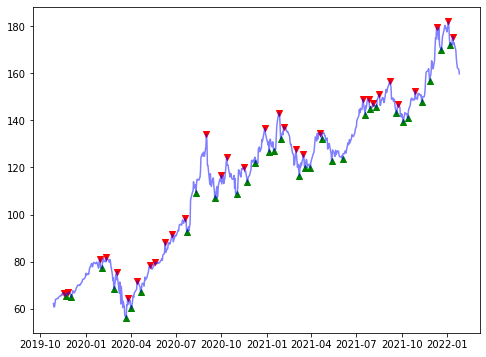

In [27]:
plot_labels(data, "AAPL")

In [28]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,...,ShortEMA,LongEMA,ShortMA,LongMA,MACD,ROC,SPY_returns,Treasury_Yield_10_Years,Sentiment,Target
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-28,61.855000,62.312500,61.680000,62.262501,61.089714,96572800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,303.299988,1.853,0,2.0
2019-10-29,62.242500,62.437500,60.642502,60.822498,59.676834,142839600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,303.209991,1.835,0,2.0
2019-10-30,61.189999,61.325001,60.302502,60.814999,59.669472,124522000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,304.140015,1.798,0,2.0
2019-10-31,61.810001,62.292500,59.314999,62.189999,61.018578,139162000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,303.329987,1.691,0,2.0
2019-11-01,62.384998,63.982498,62.290001,63.955002,62.750332,151125200,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,306.140015,1.728,0,2.0


In [29]:
data = data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,...,ShortEMA,LongEMA,ShortMA,LongMA,MACD,ROC,SPY_returns,Treasury_Yield_10_Years,Sentiment,Target
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-03,64.577499,64.882500,64.072502,64.862503,63.831814,114430400,65.758751,67.334981,64.182521,3.152460,...,65.813464,64.984424,66.156043,64.984424,0.829041,-1.214591,309.549988,1.709,0,1.0
2019-12-04,65.267502,65.827499,65.169998,65.434998,64.395210,67181600,65.816376,67.250363,64.382388,2.867975,...,65.755239,65.017800,66.072292,65.106443,0.737439,-1.512650,311.459991,1.781,0,2.0
2019-12-05,65.947502,66.472504,65.682503,66.394997,65.339943,74424400,65.920626,67.195762,64.645489,2.550273,...,65.853663,65.119814,66.040625,65.320770,0.733849,-0.569083,312.019989,1.797,0,2.0
2019-12-06,66.870003,67.750000,66.824997,67.677498,66.602081,106075600,66.061626,67.453646,64.669605,2.784041,...,66.134253,65.309272,66.132708,65.584712,0.824981,1.659838,314.869995,1.842,0,2.0
2019-12-09,67.500000,67.699997,66.227501,66.730003,65.669632,128042400,66.146376,67.483367,64.809384,2.673983,...,66.225907,65.414512,66.210417,65.759328,0.811395,1.417231,313.880005,1.829,0,2.0


## Train-Val-Test Split

In [30]:
train_size = int(len(data)*.6)
val_size = int(len(data) *.1)
test_size = len(data)-train_size-val_size

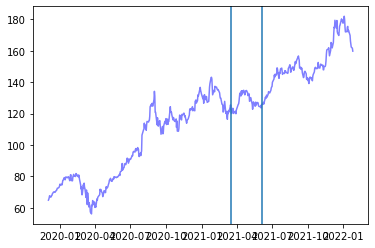

In [31]:
plt.plot(data["Close"], color = "blue", alpha = .5)
xcoords = [data.index[train_size], data.index[train_size+val_size]]
for xc in xcoords:
    plt.axvline(x=xc)

In [32]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,...,ShortEMA,LongEMA,ShortMA,LongMA,MACD,ROC,SPY_returns,Treasury_Yield_10_Years,Sentiment,Target
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-03,64.577499,64.882500,64.072502,64.862503,63.831814,114430400,65.758751,67.334981,64.182521,3.152460,...,65.813464,64.984424,66.156043,64.984424,0.829041,-1.214591,309.549988,1.709,0,1.0
2019-12-04,65.267502,65.827499,65.169998,65.434998,64.395210,67181600,65.816376,67.250363,64.382388,2.867975,...,65.755239,65.017800,66.072292,65.106443,0.737439,-1.512650,311.459991,1.781,0,2.0
2019-12-05,65.947502,66.472504,65.682503,66.394997,65.339943,74424400,65.920626,67.195762,64.645489,2.550273,...,65.853663,65.119814,66.040625,65.320770,0.733849,-0.569083,312.019989,1.797,0,2.0
2019-12-06,66.870003,67.750000,66.824997,67.677498,66.602081,106075600,66.061626,67.453646,64.669605,2.784041,...,66.134253,65.309272,66.132708,65.584712,0.824981,1.659838,314.869995,1.842,0,2.0
2019-12-09,67.500000,67.699997,66.227501,66.730003,65.669632,128042400,66.146376,67.483367,64.809384,2.673983,...,66.225907,65.414512,66.210417,65.759328,0.811395,1.417231,313.880005,1.829,0,2.0


In [33]:
train_df = data[:train_size]
val_df = data[train_size: train_size+val_size]
test_df = data[train_size+val_size:]

In [34]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,...,ShortEMA,LongEMA,ShortMA,LongMA,MACD,ROC,SPY_returns,Treasury_Yield_10_Years,Sentiment,Target
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-03,64.577499,64.882500,64.072502,64.862503,63.831814,114430400,65.758751,67.334981,64.182521,3.152460,...,65.813464,64.984424,66.156043,64.984424,0.829041,-1.214591,309.549988,1.709,0,1.0
2019-12-04,65.267502,65.827499,65.169998,65.434998,64.395210,67181600,65.816376,67.250363,64.382388,2.867975,...,65.755239,65.017800,66.072292,65.106443,0.737439,-1.512650,311.459991,1.781,0,2.0
2019-12-05,65.947502,66.472504,65.682503,66.394997,65.339943,74424400,65.920626,67.195762,64.645489,2.550273,...,65.853663,65.119814,66.040625,65.320770,0.733849,-0.569083,312.019989,1.797,0,2.0
2019-12-06,66.870003,67.750000,66.824997,67.677498,66.602081,106075600,66.061626,67.453646,64.669605,2.784041,...,66.134253,65.309272,66.132708,65.584712,0.824981,1.659838,314.869995,1.842,0,2.0
2019-12-09,67.500000,67.699997,66.227501,66.730003,65.669632,128042400,66.146376,67.483367,64.809384,2.673983,...,66.225907,65.414512,66.210417,65.759328,0.811395,1.417231,313.880005,1.829,0,2.0


# Normalization

In [35]:
norm_cols = list(train_df.columns)[:-1]

In [36]:
scaler = MinMaxScaler()
train_df[norm_cols] = scaler.fit_transform(train_df[norm_cols])

C:\Users\rudra\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rudra\Anaconda3\lib\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [37]:
# "Sentiment" 

In [38]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,...,ShortEMA,LongEMA,ShortMA,LongMA,MACD,ROC,SPY_returns,Treasury_Yield_10_Years,Sentiment,Target
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-03,0.087289,0.088188,0.123785,0.100726,0.097956,0.178346,0.045921,0.001804,0.132730,0.018783,...,0.049320,0.000000,0.066018,0.015491,0.451258,0.484428,0.496816,0.842618,0.0,1.0
2019-12-04,0.095259,0.098931,0.136226,0.107302,0.104449,0.053948,0.046701,0.000708,0.135383,0.009909,...,0.048536,0.000481,0.064922,0.017217,0.443736,0.478168,0.507773,0.892758,0.0,2.0
2019-12-05,0.103113,0.106264,0.142035,0.118328,0.115337,0.073017,0.048112,0.000000,0.138874,0.000000,...,0.049862,0.001953,0.064508,0.020248,0.443442,0.497987,0.510986,0.903900,0.0,2.0
2019-12-06,0.113768,0.120787,0.154986,0.133058,0.129883,0.156349,0.050020,0.003342,0.139194,0.007291,...,0.053642,0.004685,0.065713,0.023981,0.450925,0.544803,0.527336,0.935237,0.0,2.0
2019-12-09,0.121044,0.120218,0.148213,0.122175,0.119137,0.214184,0.051167,0.003728,0.141049,0.003859,...,0.054877,0.006203,0.066730,0.026450,0.449809,0.539707,0.521657,0.926184,0.0,2.0


## Data Preprocessing

In [39]:
train_x, train_y = train_df.iloc[:,:-1],train_df.iloc[:,-1]
train_x.head()


,Open,High,Low,Close,Adj Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,...,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,ROC,SPY_returns,Treasury_Yield_10_Years,Sentiment
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-03,0.087289,0.088188,0.123785,0.100726,0.097956,0.178346,0.045921,0.001804,0.132730,0.018783,...,0.418274,0.049320,0.000000,0.066018,0.015491,0.451258,0.484428,0.496816,0.842618,0.0
2019-12-04,0.095259,0.098931,0.136226,0.107302,0.104449,0.053948,0.046701,0.000708,0.135383,0.009909,...,0.475214,0.048536,0.000481,0.064922,0.017217,0.443736,0.478168,0.507773,0.892758,0.0
2019-12-05,0.103113,0.106264,0.142035,0.118328,0.115337,0.073017,0.048112,0.000000,0.138874,0.000000,...,0.560627,0.049862,0.001953,0.064508,0.020248,0.443442,0.497987,0.510986,0.903900,0.0
2019-12-06,0.113768,0.120787,0.154986,0.133058,0.129883,0.156349,0.050020,0.003342,0.139194,0.007291,...,0.655277,0.053642,0.004685,0.065713,0.023981,0.450925,0.544803,0.527336,0.935237,0.0
2019-12-09,0.121044,0.120218,0.148213,0.122175,0.119137,0.214184,0.051167,0.003728,0.141049,0.003859,...,0.543169,0.054877,0.006203,0.066730,0.026450,0.449809,0.539707,0.521657,0.926184,0.0


In [40]:
def create_sequences(data, window = 7):
    seq = []
    for i in range(len(data)-window):
        record = []
        for j in range(window):
            
            record.append(data.iloc[i+j].values)
        seq.append(record)

    
    return seq 


train_seq = create_sequences(train_x)

In [41]:
train_y = train_y[7:]

In [42]:
len(train_seq) == len(train_y)

True

In [43]:
train_x_seq, train_y_seq = np.array(train_seq), np.array(train_y)

In [44]:
train_x_seq.shape

(317, 7, 23)

In [180]:
#cover to tensors
train_seq_tensor = [torch.tensor(l) for l in train_seq]
train_y_tensor = [torch.tensor(l).unsqueeze(0) for l in train_y]

In [181]:
train_y_tensor[0].shape

torch.Size([1])

In [182]:
train_inout_seq = list(zip(train_seq_tensor, train_y_tensor))

In [183]:
train_inout_seq[0]

(tensor([[8.7289e-02, 8.8188e-02, 1.2378e-01, 1.0073e-01, 9.7956e-02, 1.7835e-01,
          4.5921e-02, 1.8044e-03, 1.3273e-01, 1.8783e-02, 4.5921e-02, 1.6352e-02,
          7.9210e-02, 4.1827e-01, 4.9320e-02, 0.0000e+00, 6.6018e-02, 1.5491e-02,
          4.5126e-01, 4.8443e-01, 4.9682e-01, 8.4262e-01, 0.0000e+00],
         [9.5259e-02, 9.8931e-02, 1.3623e-01, 1.0730e-01, 1.0445e-01, 5.3948e-02,
          4.6701e-02, 7.0767e-04, 1.3538e-01, 9.9093e-03, 4.6701e-02, 1.6171e-02,
          8.0955e-02, 4.7521e-01, 4.8536e-02, 4.8133e-04, 6.4922e-02, 1.7217e-02,
          4.4374e-01, 4.7817e-01, 5.0777e-01, 8.9276e-01, 0.0000e+00],
         [1.0311e-01, 1.0626e-01, 1.4204e-01, 1.1833e-01, 1.1534e-01, 7.3017e-02,
          4.8112e-02, 0.0000e+00, 1.3887e-01, 0.0000e+00, 4.8112e-02, 1.6504e-02,
          8.3445e-02, 5.6063e-01, 4.9862e-02, 1.9525e-03, 6.4508e-02, 2.0248e-02,
          4.4344e-01, 4.9799e-01, 5.1099e-01, 9.0390e-01, 0.0000e+00],
         [1.1377e-01, 1.2079e-01, 1.5499e-01, 1.3

In [184]:
 #TODO: Get a model running

## LSTM

In [189]:
NUM_FEATURES = 23
BATCH_SIZE = 1
class NetworkClassifier(torch.nn.Module):
    def __init__(self, input_size = NUM_FEATURES, hidden_size = 128, output_size = 3, batch_size = BATCH_SIZE, dropout = 0.2, num_layers=2):
        super().__init__()
        self.input_size = input_size #num of features
        self.hidden_size = hidden_size
        self.output_size = output_size    
        self.batch_size = batch_size
        self.num_layers = num_layers  

        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers)
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        # a new hidden-state (the LSTM requires, unlike RNNs, two hidden-states in a tuple)
        

    def forward(self, input_seq):
        # h_t = torch.zeros(input_seq.size(0), self.hidden_size, dtype=torch.float32)
        # c_t = torch.zeros(input_seq.size(0), self.hidden_size, dtype=torch.float32)
        hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size), torch.zeros(self.num_layers, self.batch_size, self.hidden_size))


        #print(self.hidden_cell[0].shape)
        #print(input_seq.shape)
        lstm_out, hidden = self.lstm(input_seq, hidden)
        
        # x contains the output states of every timestep, 
        # for classifiction we mostly just want the last one
        #print(out.shape)
        
        #lstm_out = lstm_out[:, -1] 
        
        #out = out.view(len(input_seq),-1)
        #print(out.shape)
        #out = self.linear(out)
        
        out = self.linear(hidden[0])
        # print(out)
        return out[-1]

In [241]:
epochs = 50
lr = .001



model = NetworkClassifier()
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=.001)

for epoch in range(epochs):
    print("epoch", epoch)
    loss_total = 0
    for i, (x, y) in enumerate(train_inout_seq):
        model.train()
       
        opt.zero_grad()
        
        x = x.view(len(x), 1, -1)
        #print(x.shape)

        #print("running")
        out = model(x.float())
        # print(out.shape)
        # print(y.shape)

        # print(out)
        y_pred = torch.argmax(out, dim=1)
        # print(torch.argmax(out, dim=1))

        loss = loss_func(out,y.type(torch.LongTensor))
        loss.backward()
        opt.step()

        loss_total += loss.item()
    print(loss_total/len(train_inout_seq))


epoch 0
0.5107309675996455
epoch 1
0.4272106817162563
epoch 2
0.42563042356059755
epoch 3
0.4246230837815568
epoch 4


In [237]:
model.eval()

preds = []

for i, (x, y) in enumerate(train_inout_seq):
    preds.append(torch.argmax(model(x.view(len(x), 1, -1).float())).item())
    

In [238]:
set(preds)

{2}

In [239]:
len(train_df)

324

In [240]:
def plot_preds_train(train_df, preds, train_size):

    window_size = 7

    df = train_df.copy()
    #df = df[7:train_size]
    df["Buy"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 1.0 else np.nan for i in range(len(df["Target"]))]
    df["Sell"] = [df.iloc[i]["Close"] if df.iloc[i]["Target"] == 0.0 else np.nan for i in range(len(df["Target"]))]

    df["Pred Buy"] = [np.nan] * window_size + [preds[i] if preds[i] == 1 else np.nan for i in range(len(preds))]
    df["Pred Sell"] = [np.nan] * window_size + [preds[i] if preds[i] == 0 else np.nan for i in range(len(preds))]

    #df["Sell"] = [df["Close"] if i == 0.0 else np.nan for i in df["Target"]]
    fig = plt.figure(figsize=(8, 6))
    plt.plot(df["Close"], color = "blue", alpha = .5)
    
    if(not df["Buy"].isnull().all()):
        plt.scatter(df.index, df["Buy"], color = 'green', marker="^", alpha=1)
    if(not df["Sell"].isnull().all()):
        plt.scatter(df.index, df["Sell"], color = 'red', marker="v", alpha=1)

    if(not df["Pred Buy"].isnull().all()):
        plt.scatter(df.index, df["Buy"], color = 'purple', marker="^", alpha=1)
    if(not df["Pred Sell"].isnull().all()):
        plt.scatter(df.index, df["Sell"], color = 'orange', marker="v", alpha=1)
    
    plt.axvline(x=data.index[train_size])
    plt.show() 
    # fig.savefig('ML_charts/{}_target_chart.png'.format(symbol))
    plt.close(fig)

In [ ]:
#overfits at 100 epochs

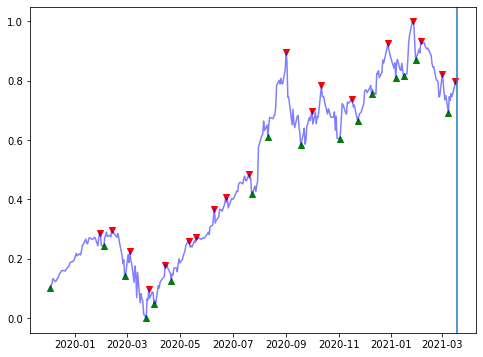

In [234]:
plot_preds_train(train_df,preds, train_size)